# 🎭📰 Workshop - Detector de Fake News 📰🎭

El objetivo de este modelo predictor es predecir el tipo de noticia (real o falsa) en función de los datos proporcionados en el conjunto de texto. Con el creciente aumento de noticias falsas, especialmente en plataformas digitales y redes sociales, la capacidad de identificar de manera automatizada si una noticia es verídica o falsa se ha vuelto crucial. Este modelo de procesamiento de lenguaje natural (NLP) tiene como propósito ayudar en la clasificación de noticias, para proporcionar una herramienta que permita identificar y etiquetar contenidos de manera eficiente.

## 🛠️ Descargas y preparacion de herramientas 🛠️

In [ ]:
# Si no hemos descargado el modelo procesador de texto en ingles:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 11.3 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 10.1 MB/s eta 0:00:01
     ----------------- ---------------------- 5.5/12.8 MB 10.2 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 10.2 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 10.2 MB/s eta 0:00:01
     ------------------------------------ -- 12.1/12.8 MB 10.3 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import nltk
import spacy
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 📔Cargar modelo de spaCy en inglés 📔

In [ ]:
nlp = spacy.load("en_core_web_sm")

## 🧫 Cargar dataset 🧫

In [4]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

## 🔍 Esta balanceado el dataframe? 🔎

([<matplotlib.patches.Wedge at 0x2346f93fda0>,
 [Text(-0.705602603597831, -0.8438749704760549, 'REAL'),
  Text(0.7056023286284262, 0.8438752003905213, 'FAKE')],
 [Text(-0.38487414741699866, -0.4602954384414844, '50.1%'),
  Text(0.38487399743368694, 0.4602955638493752, '49.9%')])

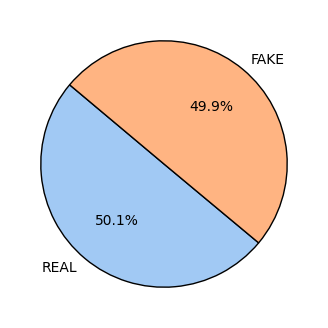

In [5]:
# Contar cuantas noticias reales y fakes hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?
sentimiento_counts = df['sentimiento'].value_counts()

# Para no perder la costumbre y seguir practicando: graficamos.
colors = sns.color_palette('pastel')
plt.figure(figsize=(4, 4))
plt.pie(sentimiento_counts,labels=sentimiento_counts.index,colors=colors,autopct='%1.1f%%',startangle=140,wedgeprops={'edgecolor': 'black'})

No hace falta balancear ya que está muy cerca del 50/50, es decir, ya está balanceado.

In [6]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?
df.shape

(6335, 4)

In [7]:
df.sample(5)

,Unnamed: 0,title,texto,sentimiento
368,9168,To the Youth a Day After the Election: Another...,By Tai Amri Spann-Wilson / 400yearsinbabylon.b...,FAKE
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6194,1736,Rand Paul's all-too-familiar campaign,"Killing Obama administration rules, dismantlin...",REAL
3254,4162,Battle over Scalia’s replacement already spill...,Conservative and liberal advocacy groups are g...,REAL
4586,4704,WashPost Poll: Clinton Leads Trump by 4,Hillary Clinton leads Donald Trump by just 4 p...,REAL


La diferencia que encuentro es que son pocas variables ya que al tratar con cadenas de texto, no se necesitan muchas variables. En este caso, con el titulo y el texto, junto con el texto, podemos ya entrenar un modelo de forma supervisado.

In [9]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

# Definir el número de muestras deseadas por clase
num_muestras_por_clase = 500  # Ajusta este número según tu necesidad

# Separar las clases
df_fake = df[df['sentimiento'] == 'FAKE']
df_real = df[df['sentimiento'] == 'REAL']

# Tomar una muestra aleatoria de cada clase manteniendo el balance
df_fake_sample = df_fake.sample(n=num_muestras_por_clase, random_state=42)
df_real_sample = df_real.sample(n=num_muestras_por_clase, random_state=42)

# Concatenar y mezclar las muestras
df_reducido = pd.concat([df_fake_sample, df_real_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el nuevo balance
df_reducido['sentimiento'].value_counts(normalize=True)

sentimiento
REAL    0.5
FAKE    0.5
Name: proportion, dtype: float64

## ❤️🅾️ Encodeamos el sentimiento 💔1️⃣

In [10]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)
# Reemplazar los valores de la columna 'sentimiento'
df_reducido['sentimiento'] = df_reducido['sentimiento'].map({'FAKE': 0, 'REAL': 1})

# Verificar los cambios
df_reducido['sentimiento'].value_counts()


sentimiento
1    500
0    500
Name: count, dtype: int64

## 📝 Preparamos el procesador de texto 📝

In [11]:
# Convertir las stopwords en un conjunto
stop_words = set(stopwords.words('english'))

In [ ]:
# Usando spaCy, pasamos al procesamiento de texto:

def preprocesar_texto(texto):
    #Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales.
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

"""
# Usando NLTK, pasamos al procesamiento de texto:

def preprocesar_texto_nltk(texto):

    #Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales usando NLTK.
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Tokenización y conversión a minúsculas
    tokens = word_tokenize(str(texto).lower())

    # Eliminación de stopwords y lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.is_alpha and token not in stop_words]

    return " ".join(tokens)
"""

# Ambas funciones hacen lo mismo, pero spaCy es más rápido y preciso en lematización, 
# mientras que NLTK es más flexible para experimentación y procesamiento básico. 🚀


'    \n    # Tokenización con nltk\n    tokens = nltk.word_tokenize(texto)\n    \n    # Filtrar stopwords y caracteres no alfabéticos\n    tokens_filtrados = [token for token in tokens if token.isalpha() and token not in stop_words]\n    \n    # Lematización con spaCy\n    doc = nlp(" ".join(tokens_filtrados))\n    lemas = [token.lemma_ for token in doc]\n    \n    return " ".join(tokens_filtrados)\n\n'

In [15]:
# Aplicar preprocesamiento

# Aplicar la función tanto al título como al texto y combinarlos
df_reducido['texto_procesado'] = df_reducido['title'].astype(str) + " " + df_reducido['texto'].astype(str)
df_reducido['texto_procesado'] = df_reducido['texto_procesado'].apply(preprocesar_texto)

# Ver un ejemplo
print(df_reducido[['texto_procesado']].head())

                                     texto_procesado
0  marco rubio strategy utterly baffle something ...
1  mike huckabee netanyahu wage stagnation former...
2  biden backer naysayer fast democrat loyal vice...
3  rick perry drop presidential race washington c...
4  jim rogers time prepare economic financial col...


## ☁️🆒 Nube de palabras 🆓☁️

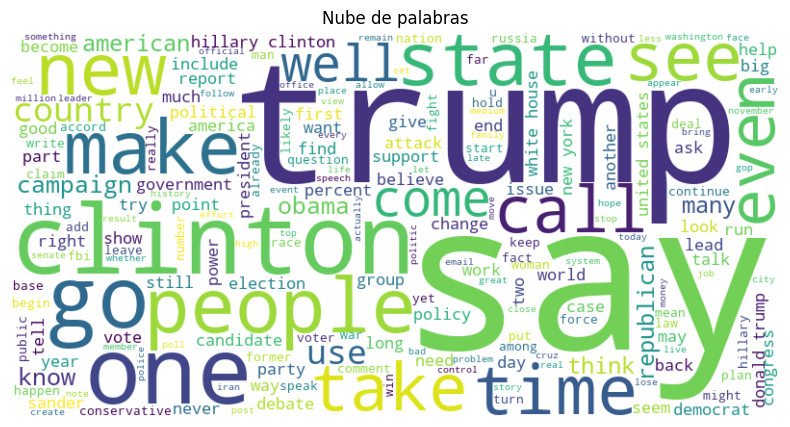

In [23]:
# Visualizar nube de palabras completando la secuencia de creación
def vis_word_cloud(df, column, width=800, height=400, background_color='white'):
    text_combined = " ".join(df[column])
    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate(text_combined)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Nube de palabras")
    plt.show()


"""
📌 Ventajas de hacerlo como función
✅ Se puede reutilizarla con cualquier DataFrame y columna.
✅ Permite personalizar el tamaño (ancho, alto) y el color de fondo.
✅ Hace que el código sea más limpio y modular. 🚀
"""


vis_word_cloud(df_reducido, 'texto_procesado')




## ⛓️📊 Analisis de N-grams ⛓️📊

Unigramas más comunes:
    N-gram  Frecuencia
0      say        4948
1    trump        3925
2  clinton        3144
3    state        2247
4    would        2204
5      one        1915
6   people        1804
7     year        1653
8      new        1631
9     make        1625


C:\Users\ingdj\AppData\Local\Temp\ipykernel_17308\155652544.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


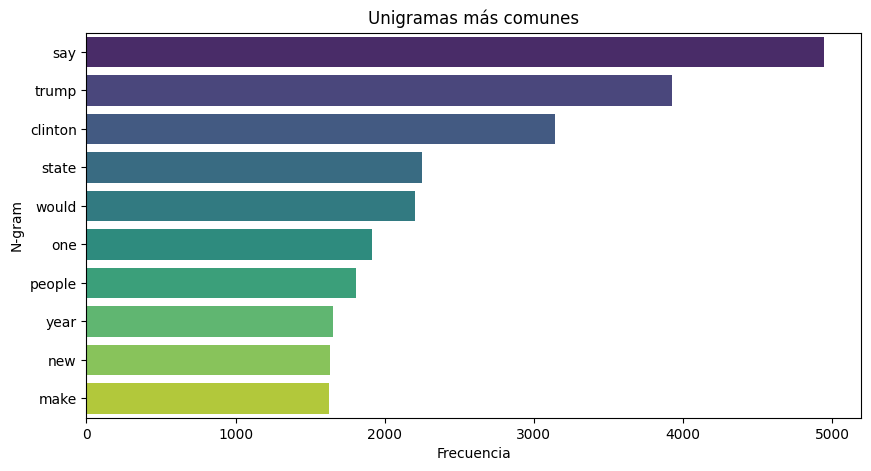


Bigramas más comunes:
             N-gram  Frecuencia
0   hillary clinton         737
1      donald trump         652
2     united states         471
3       white house         455
4          new york         420
5         trump say         230
6   secretary state         217
7   president obama         216
8     supreme court         202
9  state department         195


C:\Users\ingdj\AppData\Local\Temp\ipykernel_17308\155652544.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


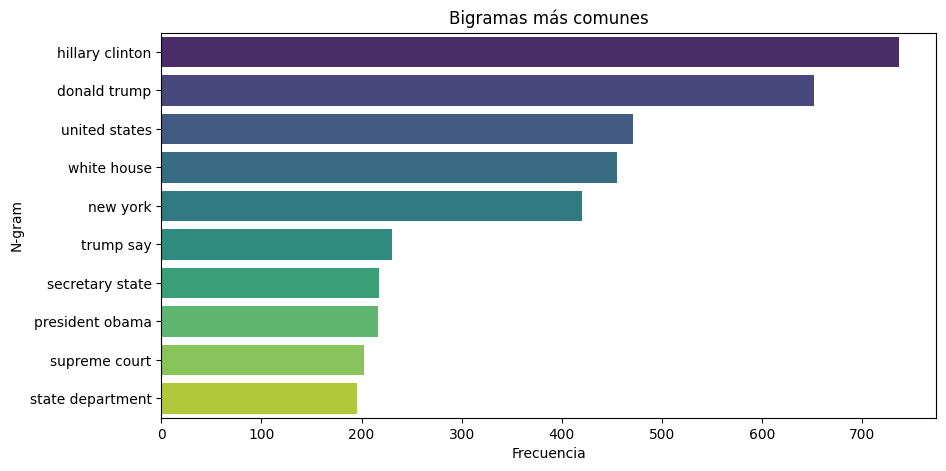


Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         134
1             president barack obama          70
2                     case case case          64
3                       sen ted cruz          45
4            president united states          44
5             former secretary state          43
6               director james comey          42
7  republican presidential candidate          41
8                 fbi director james          39
9                wall street journal          39


C:\Users\ingdj\AppData\Local\Temp\ipykernel_17308\155652544.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


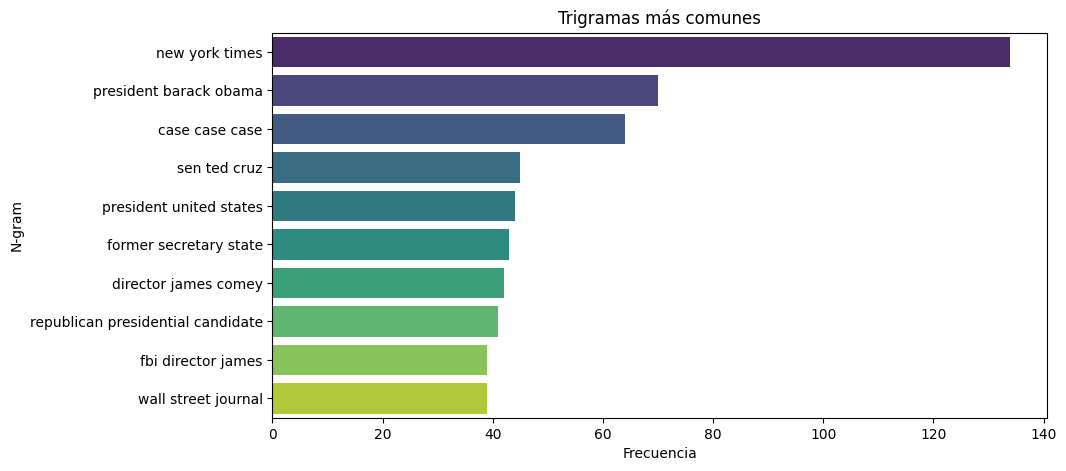

In [24]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_reducido['texto_procesado'], 1)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

bigrams = get_top_ngrams(df_reducido['texto_procesado'], 2)

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

trigrams = get_top_ngrams(df_reducido['texto_procesado'], 3)

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

## 🎢 Pipeline de vectorización y modelo MNB

In [25]:
# Separar datos en entrenamiento y prueba
X = df_reducido['texto_procesado']  # Texto preprocesado
y = df_reducido['sentimiento']  # Etiqueta (Fake/Real)

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Pipeline de vectorización y modelo MNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Incluye palabras individuales y combinaciones de 2
    ('clf', MultinomialNB()) # Modelo de Naive Bayes
])

In [31]:
# Entrenar modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [32]:
# Obtener probabilidades de predicción
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidad de ser clase "1" (Real)

In [62]:
# Ajustar umbral (por ejemplo, en lugar de 0.5 probar 0.6)
umbral = 0.70
y_pred = (y_proba >= umbral).astype(int)

In [63]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.895
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       100
           1       0.89      0.90      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



## 🧙🏻‍♂️ Vectorizacion y modelo PAC🧙🏻‍♂️

In [65]:
# Inicializar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)

# Ajustar y transformar el conjunto de entrenamiento
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transformar el conjunto de prueba
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# Inicializar el modelo PAC
pac=PassiveAggressiveClassifier(max_iter=250)

# Ajustar el clasificador al conjunto de entrenamiento
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=250)

In [132]:
# Predecir en el conjunto de prueba
y_pred2=pac.predict(tfidf_test)

In [133]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       100
           1       0.94      0.89      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



## 🎏 Comparación de resultados entre MNB y PAC 🎏

### Conjunto de resultados para MNB (después de ajustar el umbral a 0.70):

Accuracy: 0.90

Precision: Aproximadamente 0.90 para ambas clases

Recall: Aproximadamente 0.90 para ambas clases

F1-Score: Cerca de 0.90 para ambas clases

### Conjunto de resultados para PAC (con max_iter=250):

Accuracy: 0.92

Precision: 0.94 (Clase 1) y 0.90 (Clase 0)

Recall: 0.89 (Clase 1) y 0.94 (Clase 0)

F1-Score: Cerca de 0.91 para ambas clases

## 👑 ¿Qué modelo es mejor? 👑

Accuracy: PAC es ligeramente mejor con un 0.92 frente a 0.90 de MNB.

Precisión y Recall: Ambos modelos tienen una precisión y recall muy similares. Sin embargo, PAC parece tener una mejor precisión para la clase 0 (Fake News), mientras que MNB tiene un rendimiento muy equilibrado entre ambas clases.

F1-Score: Ambos modelos tienen F1-scores altos, pero PAC tiene un F1-Score más alto en la clase 0 (Fake News), lo que podría ser relevante si prefieres capturar mejor las Fake News.

## ➕ Consideraciones adicionales ➕

Tiempo de entrenamiento: El Passive Aggressive Classifier suele ser más rápido y eficiente cuando tienes datos grandes o cuando se necesita un modelo en línea.

Complejidad: MNB es más sencillo y generalmente más fácil de interpretar, mientras que PAC podría ser más complejo debido a su naturaleza de actualización incremental.